In [1]:

##Server
import  time, sys , serial
import threading
import pprint
import time
from Serial_ import *
SERIAL_PORT_ROBOT = '/dev/ttyACM0'
SERIAL_PORT_COllECTOR = '/dev/ttyACM1'
SERIAL_RATE = 115200
import threading
from collections import deque
import TCP_IP as Tcp_Ip
clientCount = 0


buf_broadcast = deque([]) # Queue of message for broadcasting via TCP IP
buf_stm = deque([])

buf_stm

if __name__ == '__main__':
    BUFFER_SIZE = 1024
    ser = serial.Serial(SERIAL_PORT_ROBOT, SERIAL_RATE) # Connection to STM32 ROBOT
    
    serial_T = serialTread(ser)
    
    threading.Thread(target=serial_T.run, args=(buf_broadcast,buf_stm)).start()#create serial thread for robot control
    #conn, addr = Tcp_Ip.enable_tcp_com(BUFFER_SIZE)
    time.sleep(1)

#Changer les action_In et action_Out en queue de dictionaire

In [2]:
import numpy as np
import math
import robot as Robot
import Astar as Path_Generator
import Mapping as Map_Generator

import matplotlib.pyplot as plt
from parse import *
%matplotlib inline
def Main_Loop(Set_Objective,robot,mapper):
    checkpoint_ = []
    path=None
    G=None
    while(not(robot.Has_reached_final_position(Set_Objective))):
        #print(Tcp_Ip.check_data_received(conn, BUFFER_SIZE))
        print('Get_Map')
        grid = mapper.map()#Get the actual Map
        Get_Pos=robot.get_position()# Get the actual robot Position
        print('Astar Beginning')
        verified_Obj = Path_Generator.validate_objective(Set_Objective,grid, Get_Pos)
        
        Stopedby_Obstacle = 0
        theta_robot = robot.get_position()[2]
        x_start = robot.get_position()[0] + 330*math.cos(theta_robot)
        y_start = robot.get_position()[1] + 330*math.sin(theta_robot)

        path, cost , G = Path_Generator.AStarSearch((x_start,y_start), (verified_Obj[0],verified_Obj[1]), grid) #Try to find the best path
        checkpoint = Path_Generator.find_vertice(path)#Simplify the path to be straight line
        checkpoint = Path_Generator.checkpoint_corrector(checkpoint)
        #new_x,newy,theta_robot = Path_Generator.checkpoint_in_fov(robot,checkpoint)#Try to avoid backward movement unless it is too far back
        #checkpoint = Path_Generator.checkpoint_corrector(checkpoint)#Eliminate again some short path line 
        #print("OLD CHECKPOINT", checkpoint)
        #checkpoint = np.insert(checkpoint,0,[new_x,newy]).reshape((-1,2))# Add repositionning for avoiding backward movement
        #print("NEW CHECKPOINT", checkpoint)
        print('Astar End')

        """Concatenate Displacement Movement"""
        Set_Coordinate=np.zeros((len(checkpoint),4))
        Set_Coordinate[:,0]=checkpoint[:,0]
        Set_Coordinate[:,1]=checkpoint[:,1]
        Set_Coordinate[:,2]=500;
        Set_Coordinate[:,3]=8000;
        """Calculate Optimal Timeout"""
        tempX , tempY, _  = robot.get_position()
        for i in range(len(Set_Coordinate)): 
            time_out_com = math.sqrt( np.float_power(Set_Coordinate[i,0]-tempX , 2) + np.float_power(Set_Coordinate[i,1]-tempY , 2) ) / Set_Coordinate[i,2]
            Set_Coordinate[i,3] = time_out_com*1400 + 1500# 140 %(For incertenties +500 ms(For initial acceleration)
            tempX = Set_Coordinate[i,0]
            tempY = Set_Coordinate[i,1]
        print(Set_Coordinate)
        """Beginning of the loop for each coordinate the robot has to go through"""

        buf_broadcast.clear()#CLear receiving buffer
        Offset_Timeout=1500;#Raspberry timeout for lack of communication 
        Max_Try=2;#Number of try to send that message
        Try =0
        j=0
        while j <len(Set_Coordinate) and Stopedby_Obstacle ==0:
            print(j)
            """Get information of one movement"""
            X_Des=Set_Coordinate[j][0]
            Y_Des=Set_Coordinate[j][1]
            Max_Speed=Set_Coordinate[j][2]
            TimeOut=Set_Coordinate[j][3]
            """Create messages"""
            G0_String='G0 X' + str(X_Des)+' Y'+str(Y_Des)+' T'+str(TimeOut)+'\r\n'
            M201_String='M201 H0 S' + str(Max_Speed)+'\r\n'
            M3_String='M3 H3\r\n'
            All_Commands=[G0_String,M201_String,M3_String]
            Finished_Command=0
            Saved_Time=time.time()
            for i in range(0,len(All_Commands)):
                buf_stm.append(All_Commands[i])#Send every messages
            while(Finished_Command==0 and ((time.time()-Saved_Time)<(Set_Coordinate[j][3]+Offset_Timeout)/1000)) :
                #No "M0" message from the STM32 and still on time according to the Raspi
                if(buf_broadcast):
                    received=buf_broadcast.popleft()
                    print(received)
                    str2=parse("M{} X{} Y{} A{} T{} S{}",received)
                    if(str2 is not None):
                        array_argument=np.zeros(6)
                        for i in range(0,6):
                            array_argument[i]=float(str2[i])
                        if (array_argument[0]==0):
                            robot.set_position(array_argument[1],array_argument[2],array_argument[3])
                            if array_argument[4]==0: #T0 argument Arrived or sensor
                                Finished_Command=1#M0 has been received, do the next command
                                print('Finished')
                            elif array_argument[4]==1:
                                Finished_Command=1
                                print('Timeout')
                            elif array_argument[4]==2:
                                Finished_Command=1
                                Stopedby_Obstacle=1
                                print('Obstacle')
                            feedback_sensors = int(array_argument[5])# feedback sensor MLKJIHGFEDCBA 
                            mapper.new_obstacle(robot.sensor_state(feedback_sensors))
                        else:
                            print('Not M0 Frame',array_argument[0])
                    else:#Not an M0 frame 
                        pass
            if(Finished_Command==0 and Try<Max_Try):
                print('Lack of answer from STM32, Try Number '+str(Try+1))
                Try=Try+1
            else:
                j=j+1
                Try =0
            """End of try for one coordinate"""

        print('End of total movement')
        print('Requesting Bottle coordinate')
        #list_bottle_coordinate = Tcp_Ip.check_data_received(conn, BUFFER_SIZE)
        #print("New bottle coordinate: ",list_bottle_coordinate)
        #if list_bottle_coordinate != None:
        #    mapper.new_bottle(list_bottle_coordinate)
            
            
    return path, G , checkpoint

In [3]:
buf_stm.append("G92 X250 Y250 A0\r\n") 
print('Position Set')
robot = Robot.robot(250,250,0)

print('Robot objet Set')
mapper = Map_Generator.Mapping()

Position Set
Robot objet Set


Map objet Set
Main_Loop
Get_Map
Astar Beginning
Astar End
[[2000.  250.  500. 6400.]]
0
OK: X=2000.00 YOK: X=2000.00 Y=250.00 A=0.00

Lack of answer from STM32, Try Number 1
0
Lack of answer from STM32, Try Number 2
0
OK: D_Profil S=500 A=5OK: D_Profil S=500 A=50 B=100 

OK: M3 H3 S15

M0 X837.35 Y269.24 A1.45 T2 S6144

Obstacle
{'m': 1, 'f': 0, 'd': 0, 'l': 1, 'a': 0, 'k': 0, 'j': 0, 'c': 0, 'e': 0, 'g': 0, 'b': 0, 'i': 0, 'h': 0}
End of total movement
Requesting Bottle coordinate
Get_Map
Astar Beginning
Astar End
[[1670.           20.          500.         3927.13328847]
 [1900.          250.          500.         2410.75353417]
 [2000.          250.          500.         1780.        ]]
0
OK: X=1670.0OK: X=1670.00 Y=20.00 A=0.00

OK: D_Profil S=500 A=50 B=100 

OK: M3 H3 S15

M0 X838.98 Y269.12 A-12.29 T2 S5120

Obstacle
{'m': 1, 'f': 0, 'd': 0, 'l': 0, 'a': 0, 'k': 1, 'j': 0, 'c': 0, 'e': 0, 'g': 0, 'b': 0, 'i': 0, 'h': 0}
End of total movement
Requesting Bottle coordinate
Get_Map


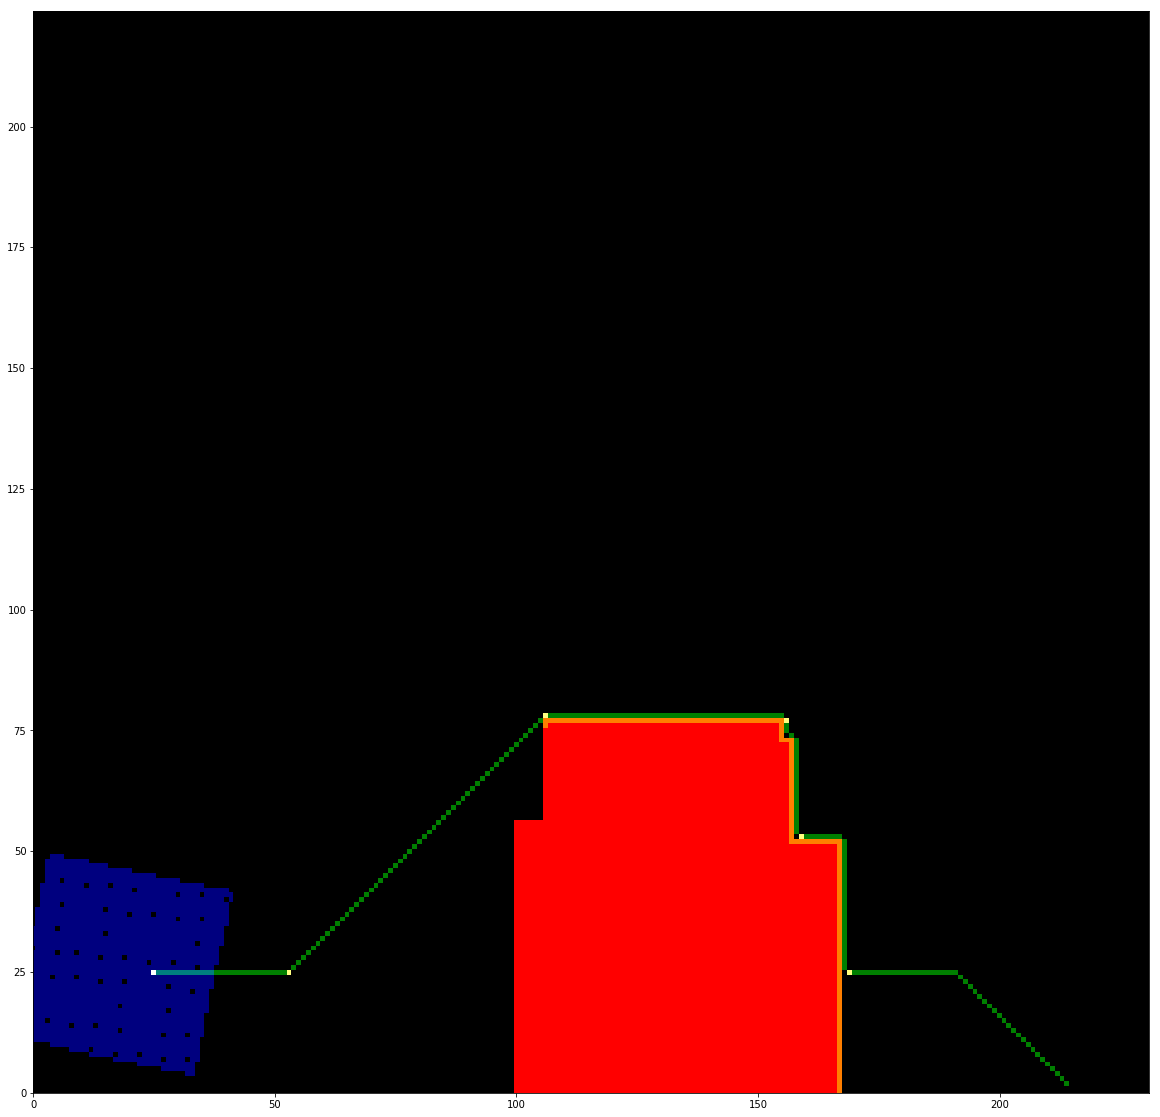

In [4]:


print('Map objet Set')
Set_Objective=[[2000,250],[250,250]]
print('Main_Loop')
for e in Set_Objective:
    path_,G_ ,checkpoint_ =Main_Loop(e,robot,mapper)
mapper.display(G_,path_,robot,checkpoint_);


In [9]:
import robot as Robot
import Astar as Path_Generator
import Mapping as Map_Generator
import numpy as np
import matplotlib.pyplot as plt
from parse import *
import math
%matplotlib inline
mapper.display(G_,path_,robot,checkpoint_);

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
#M0 X1401.47 Y329.98 A-40.82 T1 S0
mapper.display(G,path,robot)
path, cost , G = Path_Generator.AStarSearch((Get_Pos[0],Get_Pos[1]), (Set_Objective[0][0],Set_Objective[0][1]), grid) #Try to find the best path
plt.imshow(grid,origin='lower')

In [9]:

buf_stm.append("M3 H3\r\n")#Send every messages


In [12]:
buf_broadcast

deque(['STM32_PrimarySTM32_PrimarySTM32_PrimarySTM32_PrimarySTM32_PrimarySTM32_PrimarySTM32_PrimarySTM32_PrimaryOK: X=250.00 Y=250.00 A=0.00 \r\n'])

In [17]:
mapper.display(G,path,robot);

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-8ee425441f44>", line 1, in <module>
    mapper.display(G,path,robot);
NameError: name 'mapper' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/ultratb.py", line 1095, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/ultr

NameError: name 'mapper' is not defined

In [ ]:
Map_Rewards is a map of rewards(aka bottle or special zone according to the time of the game)
Map_terrain is a map of obstacle and wall 

while(running)
    if(Robot_has_reached_final_position)
        Get_Interresting_Position_To_Go();
    Set_Of_Coordinate=Calculate_Path(Actual_Pos,Position_To_Go,Map_terrain)
    for i in Set_Of_Coordinate
    #From here 
        Send set_of_Coordinate[i]
        Wait_for_answer
        Get_Position of the robot and state
        Actual_Pos=Correlation(Beacon,Robot_Pos)
        if State==Blocked
            Add_To_Map(Actual_Pos,Sensor_Trigged)
            break for loop
        else if State== Finished_Action
            continue
    #to here the robot can move
    Bottle_detection_behavior(Actual_Pos,Map_Rewards)

(-1800.0, 600.0, -1.5172760583355815)
{'i': 0, 'h': 0, 'f': 0, 'j': 0, 'b': 0, 'e': 0, 'a': 0, 'c': 0, 'k': 0, 'd': 0, 'l': 0, 'm': 1, 'g': 0}
object [3000, 1500]
grid_value 0


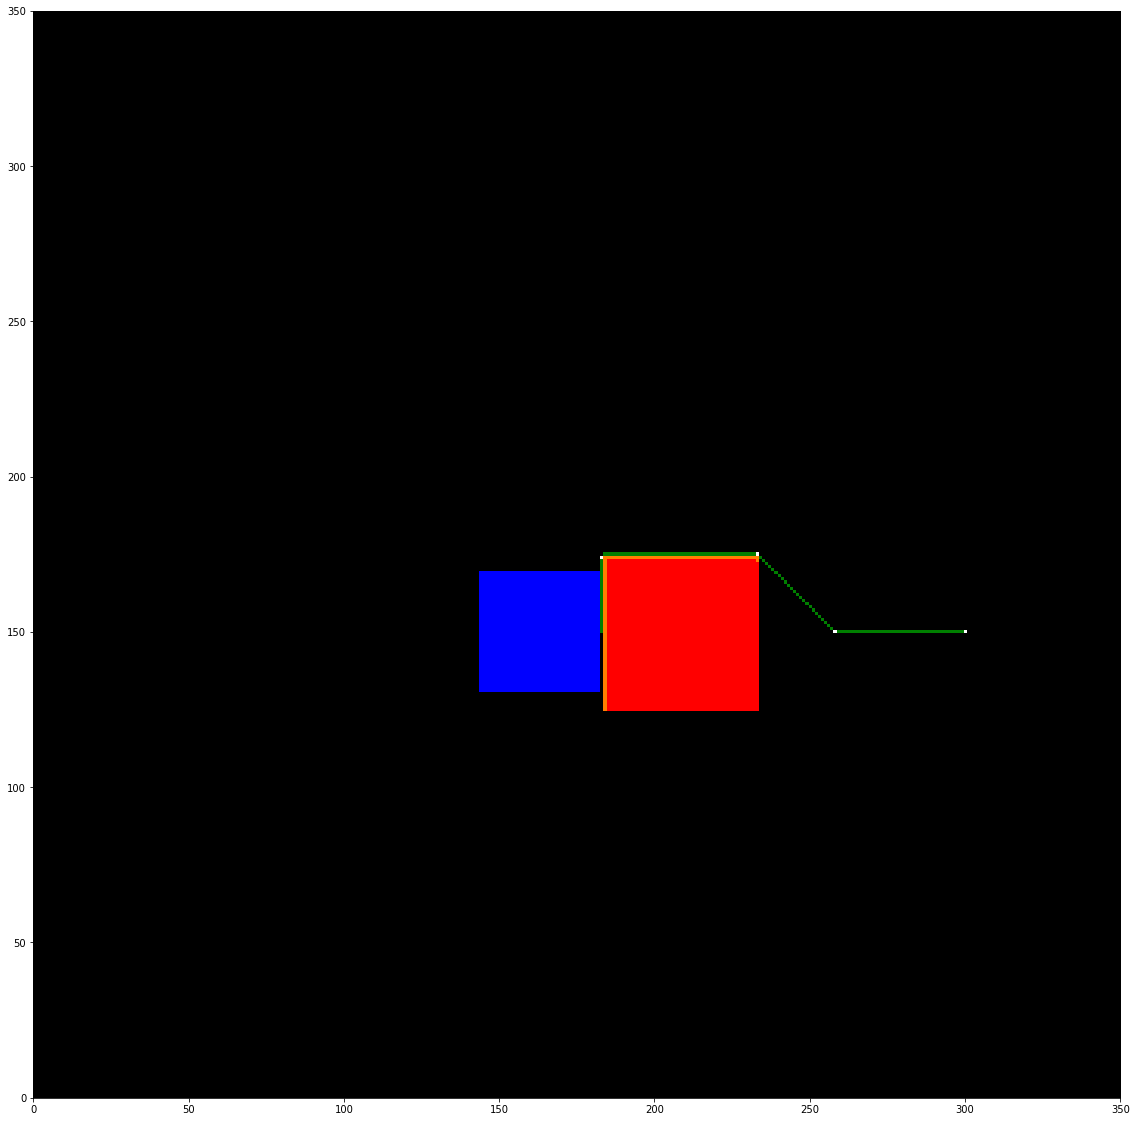

In [4]:
import robot as Robot
import Astar as Path_Generator
import Mapping as Map_Generator
import numpy as np
import matplotlib.pyplot as plt
from parse import *
import math
%matplotlib inline
robot = Robot.robot(1500,1500,0)

print(robot.get_beacon_position())
#print(robot.sensor_state(2048+16))
mapper = Map_Generator.Mapping()
grid_updated=mapper.map()

#XY = robot.sensor_state(1+2+4096)
mapper.new_obstacle(robot.sensor_state(4096  ))

#mapper.new_obstacle([[300,160]])
grid_updated=mapper.map()
objective = [3000,1500]
#list_bottle_coordinate = Tcp_Ip.check_data_received(conn, BUFFER_SIZE)
#if list_bottle_coordinate != None:
#    mapper.new_bottle(list_bottle_coordinate)

print("object",objective)
print("grid_value",grid_updated[round(objective[1]/10),round(objective[0]/10)])
valid_objective = Path_Generator.validate_objective(objective,grid_updated, robot.get_position())
theta_robot = robot.get_position()[2]
x_start = robot.get_position()[0] + 330*math.cos(theta_robot)
y_start = robot.get_position()[1] + 330*math.sin(theta_robot)

path, cost , G = Path_Generator.AStarSearch((x_start,y_start), (valid_objective[0],valid_objective[1]), grid_updated)#Try to find the best path
checkpoint = Path_Generator.find_vertice(path)#Simplify the path to be straight line
#checkpoint = Path_Generator.checkpoint_corrector(checkpoint)
new_x,newy,theta_robot = Path_Generator.checkpoint_in_fov(robot,checkpoint)
mapper.display(G,path,robot,checkpoint)


In [3]:
checkpoint

array([[1450, 1670],
       [1480, 1780],
       [1640, 1940],
       [2220, 1930],
       [2650, 1540],
       [3000, 1500]])

In [2]:
checkpoint

array([[1830, 1510],
       [1830, 1740],
       [2330, 1750],
       [2580, 1500],
       [3000, 1500]])

In [6]:
for c in checkpoint:
    print(int(c[1]/10),round(c[0]/10))

167 145.0
178 148.0
194 164.0
193 222.0
154 265.0
150 300.0


In [7]:
%load_ext autoreload


In [10]:
%autoreload 2